## Minimal Code to Evaluate A Neural Compression Model on SDO Image Data

#### 1. Importing required modules

In [1]:
import math

from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from compressai.zoo import load_state_dict, models


from compressai.models import WACNN

In [2]:

!pip install -e.

Obtaining file:///home/nlab/PycharmProjects/attentionals/attentionals
  Preparing metadata (setup.py) ... done
  Attempting uninstall: compressai
    Found existing installation: compressai 1.1.6.dev0
    Uninstalling compressai-1.1.6.dev0:
      Successfully uninstalled compressai-1.1.6.dev0
  Running setup.py develop for compressai


#### 2. Define saved checkpoint path/image path to be compressed, and the preferred device to use

In [3]:
checkpoint_path = '/home/nlab/PycharmProjects/attentionals/attentionals/ckpt_n/multispec_3D_convolution_113_0.5_3-3_18ch_ga._bestpath.tar'
image_path = '/home/nlab/data/multispectral_data/test_small/AIA20150901_1024.npy'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
def rename_key(key: str) -> str:
    """Rename state_dict key."""

    # Deal with modules trained with DataParallel
    if key.startswith("module."):
        key = key[7:]

    # ResidualBlockWithStride: 'downsample' -> 'skip'
    # if ".downsample." in key:
    #     return key.replace("downsample", "skip")  # commented for nlpr

    # EntropyBottleneck: nn.ParameterList to nn.Parameters
    if key.startswith("entropy_bottleneck."):
        if key.startswith("entropy_bottleneck._biases."):
            return f"entropy_bottleneck._bias{key[-1]}"

        if key.startswith("entropy_bottleneck._matrices."):
            return f"entropy_bottleneck._matrix{key[-1]}"

        if key.startswith("entropy_bottleneck._factors."):
            return f"entropy_bottleneck._factor{key[-1]}"

    return key


#### 3. Load model with pretrained weights

In [5]:
state_dict = torch.load(checkpoint_path)['state_dict']
net = WACNN.from_state_dict(state_dict).eval().to(device)

/home/nlab/anaconda3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
checkpoint = torch.load(checkpoint_path)
state_dict = load_state_dict(torch.load(checkpoint_path)['state_dict'])

#### 4. Read the candidate image and plot it for visualization

(9, 512, 512)
shape of projected (262144, 9)
img shape, (9, 512, 512)


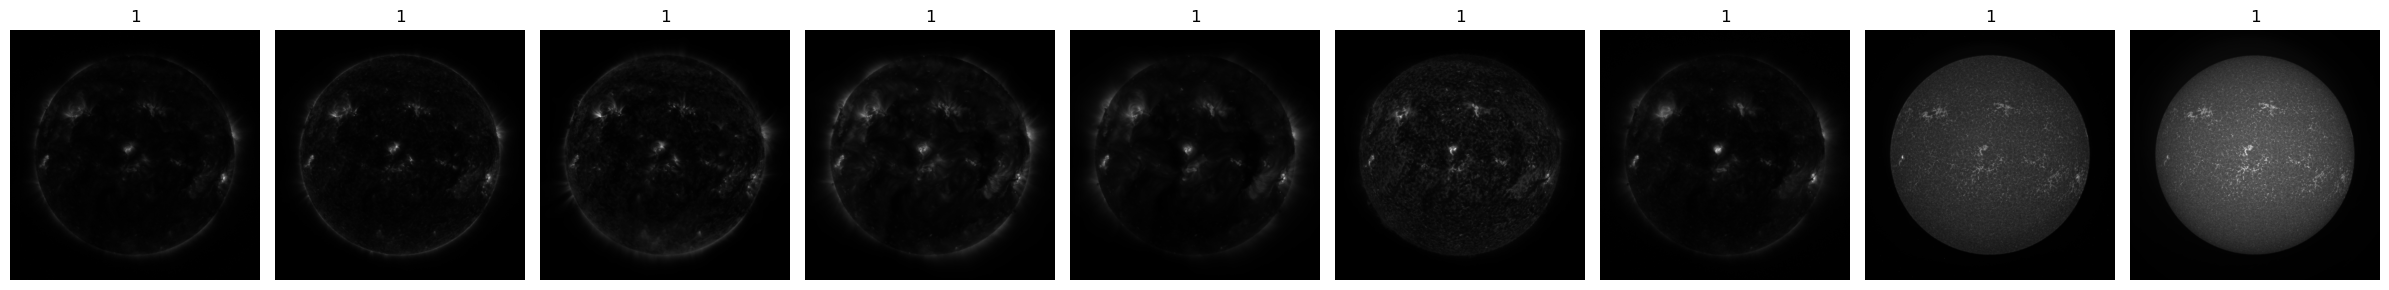

In [7]:
import numpy as np


def extract_patches(images, patch_size=(8, 8)):
    channels, height, width = images.shape
    patch_height, patch_width = patch_size
    num_patches = (height // patch_height) * (width // patch_width)
    patches = np.zeros((num_patches, channels, patch_height, patch_width))
    patch_index = 0
    for h in range(0, height, patch_height):
        for w in range(0, width, patch_width):
            patch = images[:, h:h + patch_height, w:w + patch_width]
            patches[patch_index] = patch
            patch_index += 1
    return patches


# Step 2: Flatten each patch to create a dataset
def flatten_patches(patches):
    num_patches, channels, patch_height, patch_width = patches.shape
    flattened_patches = patches.reshape(num_patches, channels * patch_height * patch_width)
    return flattened_patches


def component_getter(images, num_components=9):
    # Load your original image data (shape: (9, 512, 512))
    original_image = images  # Replace this with your actual image data
    num_channels=9
    # Extract patches from the original image
    #patches = extract_patches(original_image)

    # Flatten the patches
    #flattened_patches = flatten_patches(patches)

    #flattened_images = flattened_patches.T
    flattened_images = images.reshape(num_channels,-1)
    # Step 1: Find the mean across each channel
    channel_means = (np.mean(flattened_images, axis=1, keepdims=True))
    # print(channel_means.shape)

    # Step 2: Subtract the mean from each value in the corresponding channel
    centered_images = (flattened_images - channel_means)

    #covariance_matrix = np.dot(centered_images, centered_images.T) / (512 * 512 - 1)
    #print(covariance_matrix)
    covariance_matrix=np.cov(flattened_images)
    #print("shape of covariance matrix,",covariance_matrix.shape)

    # Step 2.1: Perform eigenvalue decomposition using np.linalg.eigh()
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Step 2.2: Sort the eigenvalues and corresponding eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]  # Get indices to sort eigenvalues in descending order
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    nums_component_for_rec = num_components


    eigenvectors_subset = eigenvectors[:, :nums_component_for_rec]
    projected_data = np.dot(centered_images.T, eigenvectors_subset)
    print("shape of projected",  projected_data.shape)
    projected_data_reshaped = projected_data.T.reshape(9,512,512)

    

    return projected_data_reshaped


img_o = np.load(image_path)
print(img_o.shape)
images=[]
for image in img_o:

    #image[image < 1] = 1
    #image = np.log2(image)
    #image *= (255.0 / image.max())
    image = ((image - image.min()) * (255.0 / (image.max() - image.min())))
    image= image/255.0
    image = image.astype(np.float32)
    # PIL_image=Image.fromarray(image.astype('uint8'))

    if image.ndim == 3 and image.shape[0] == 1:
        image = image.squeeze(0)

    image = np.array(image)

    images.append(image)
    
    # i+=1
# print("shape of images",len(images))
# print("the value of i ", i)
img = np.stack(images, axis=0)

imgT = np.transpose(img, (1, 2, 0))


pca = component_getter(img)
#pca=torch.tensor(pca)
pca_T = np.transpose(pca, (1, 2, 0))
#pca_T = pca#.transpose(1,2).transpose(0,1)
print("img shape,",img.shape)

x=transforms.ToTensor()(imgT).unsqueeze(0).to(device)
#x=transforms.RandomCrop(256,256)(x)
#pca = pca_T.unsqueeze(0).to(device)#transforms.ToTensor()(pca_T).unsqueeze(0).to(device)





'''
%matplotlib inline
fig,axes = 
plt.figure(figsize=(12, 9))
plt.axis('off')
plt.imshow(img[i], cmap='gray')
plt.show()'''


num_images = len(img)
cols = num_images  # Number of columns equals the number of images

# Create a figure and axes
fig, axes = plt.subplots(1, cols, figsize=(24,16))

# Loop through each image and plot it
for i in range(num_images):
    axes[i].imshow(img[i], cmap="gray")
    axes[i].set_title(1)

    axes[i].axis("off")

plt.tight_layout()
plt.show()



#### 5. Feed the network and get the reconstruction + required bit-rate

In [8]:
with torch.no_grad():
    out_net = net.forward(x)
out_net['x_hat'].clamp_(0, 1)
print(out_net.keys())

'''
print("shape of the pca",x.shape)
num_rows=12
num_cols=12
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))
z=x.reshape(64,64,144)
z=z.to('cpu')
for i in range(num_rows):
    for j in range(num_cols):
        pc_index = i * num_cols + j
        if pc_index < 576:
            pc_image = z[:, :, pc_index]
            unstacked_image = np.squeeze(pc_image)
            axes[i, j].imshow(unstacked_image, cmap='gray')
            axes[i, j].set_title(f"PC{pc_index+1}")
            axes[i, j].axis('off')
        else:
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()
'''


dict_keys(['x_hat', 'likelihoods'])


'\nprint("shape of the pca",x.shape)\nnum_rows=12\nnum_cols=12\nfig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))\nz=x.reshape(64,64,144)\nz=z.to(\'cpu\')\nfor i in range(num_rows):\n    for j in range(num_cols):\n        pc_index = i * num_cols + j\n        if pc_index < 576:\n            pc_image = z[:, :, pc_index]\n            unstacked_image = np.squeeze(pc_image)\n            axes[i, j].imshow(unstacked_image, cmap=\'gray\')\n            axes[i, j].set_title(f"PC{pc_index+1}")\n            axes[i, j].axis(\'off\')\n        else:\n            axes[i, j].axis(\'off\')\n\nplt.tight_layout()\nplt.show()\n'

In [9]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

#### 6. Report PSNR and Bit-rate 

In [10]:
print(f'PSNR: {compute_psnr(x, out_net["x_hat"]):.4f}dB')
print('shape of x ', x.shape)
print('shape of outnet',out_net["x_hat"].shape)
print(f'Bit-rate: {compute_bpp(out_net):.3f} bpp')

PSNR: 44.5051dB
shape of x  torch.Size([1, 9, 512, 512])
shape of outnet torch.Size([1, 9, 512, 512])
Bit-rate: 0.900 bpp


#### 7. Visualize the reconstruction

1.0
1.0009766
1.0009766


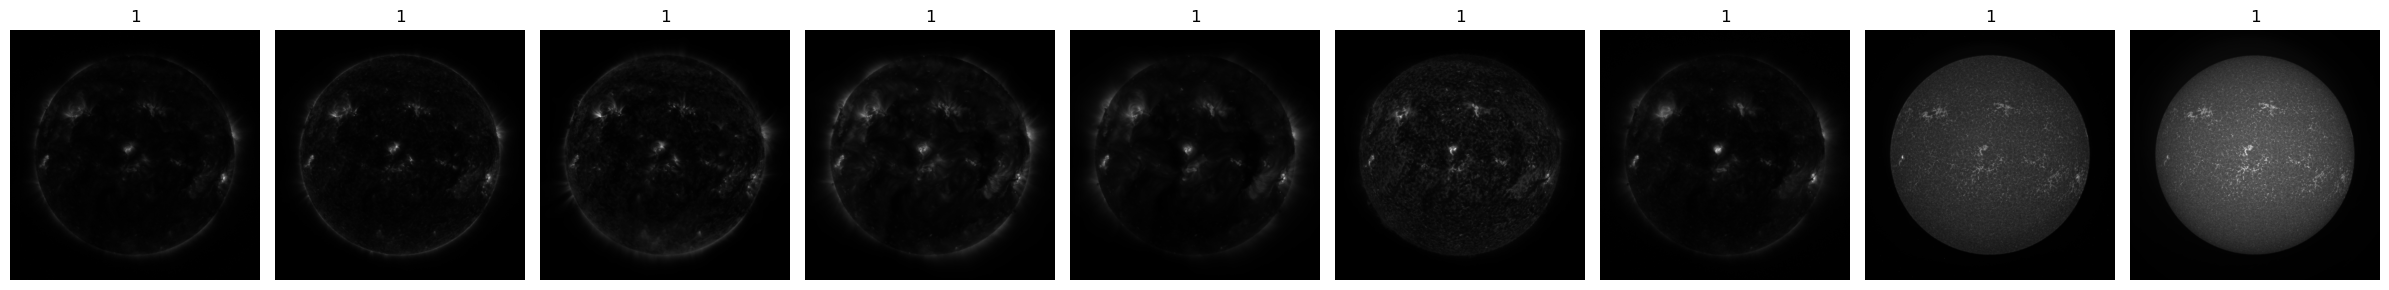

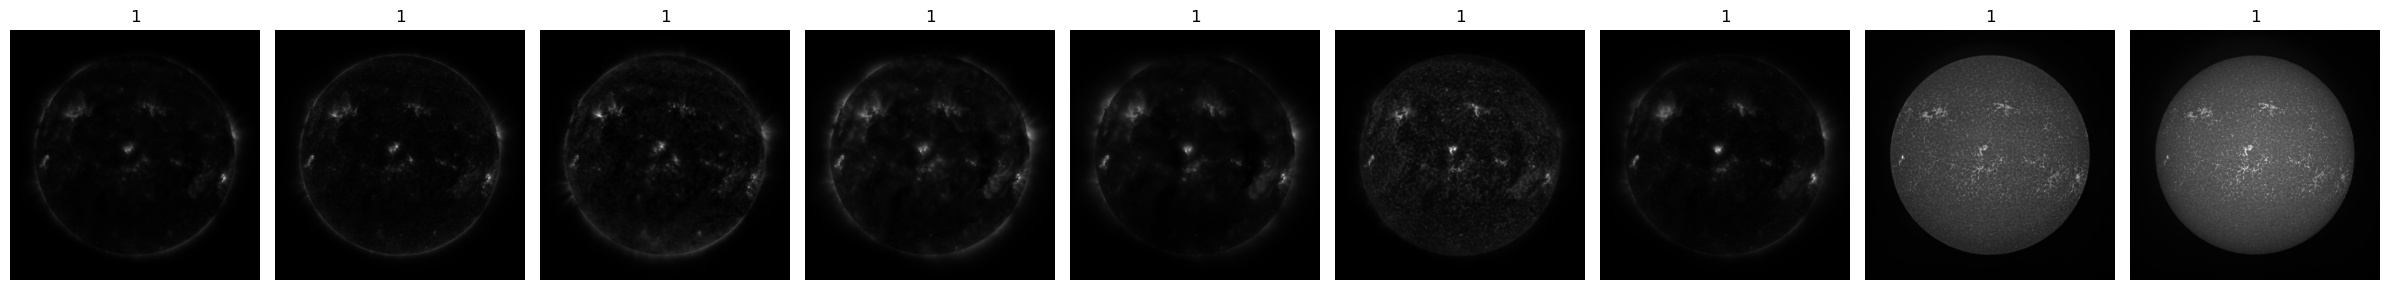

In [12]:
rec_net =np.array((out_net['x_hat'].squeeze().cpu()))
org_x =np.array((x.squeeze().cpu()))
"""
%matplotlib inline
fix, axes = plt.subplots(1, 2, figsize=(16, 12))
for ax in axes:
    ax.axis('off')
    
axes[0].imshow(img, cmap='gray')
axes[0].title.set_text('Original')

axes[1].imshow(rec_net, cmap='gray')
axes[1].title.set_text('Reconstructed')


plt.show()"""

print(np.max(rec_net))
print(np.max(imgT))
print(np.max(org_x))



# Create a figure and axes
fig, axes = plt.subplots(1, 9, figsize=(24,16))

# Loop through each image and plot it
for i in range(9):
    axes[i].imshow(org_x[i], cmap="gray")
    axes[i].set_title(1)

    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Create a figure and axes
fig, axes = plt.subplots(1, 9, figsize=(24,16))

# Loop through each image and plot it
for i in range(9):
    axes[i].imshow(rec_net[i], cmap="gray")
    axes[i].set_title(1)

    axes[i].axis("off")

plt.tight_layout()
plt.show()


(9, 512, 512)
(9, 512, 512)
1e-11
0.0
127490.516
PSNR: -35.2567dB


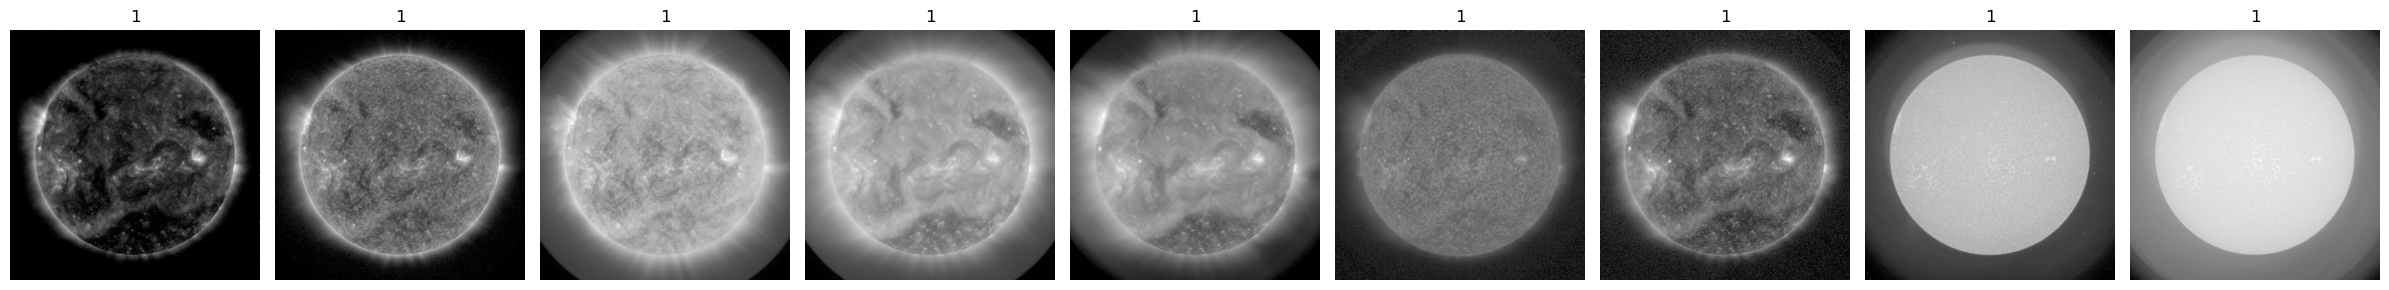

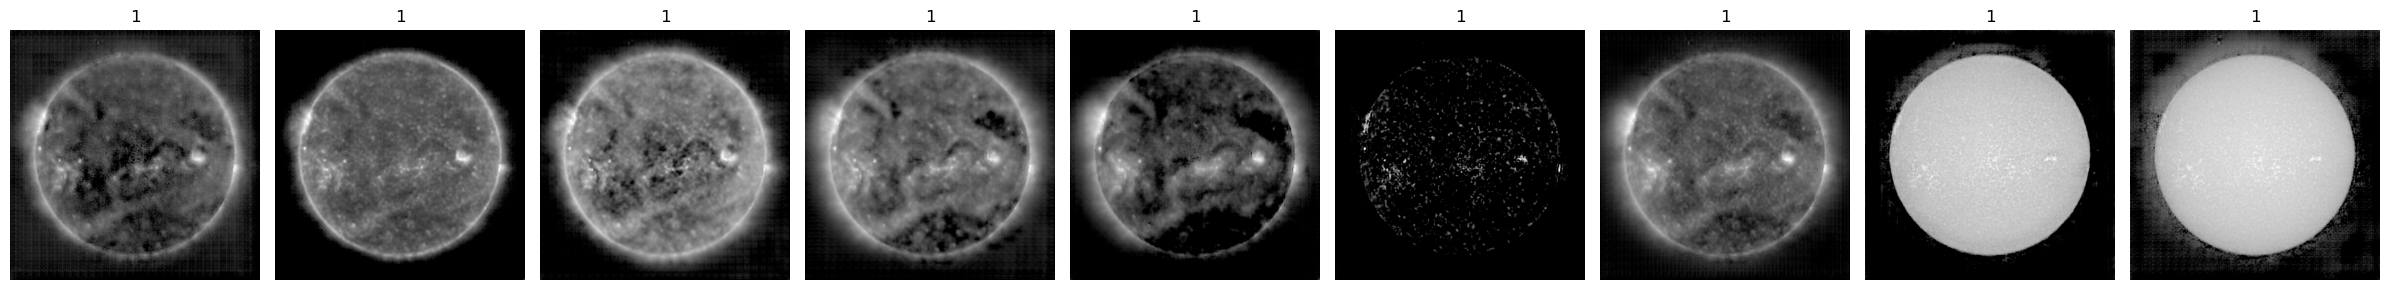

In [23]:
images_o=[]
print(img_o.shape)
for image in img_o:

    image[image < 1] = 1
    image = np.log2(image)
    image *= (255.0 / image.max())
    #image = image.astype(np.uint8)
    # PIL_image=Image.fromarray(image.astype('uint8'))

    if image.ndim == 3 and image.shape[0] == 1:
        image = image.squeeze(0)

    image = np.array(image)

    images_o.append(image)
    
    # i+=1
# print("shape of images",len(images))
# print("the value of i ", i)
o = np.stack(images_o, axis=0)
print(img_o.shape)



images_rec=[]
rec =np.array((out_net['x_hat'].squeeze().cpu()))+0.00000000001
print(np.min(rec))
for image in rec:

    
    image*=255.0
    image[image < 1] = 1
    image = np.log2(image)
    image *= (255.0 / image.max())
    #image = image.astype(np.uint8)
    # PIL_image=Image.fromarray(image.astype('uint8'))

    if image.ndim == 3 and image.shape[0] == 1:
        image = image.squeeze(0)

    image = np.array(image)

    images_rec.append(image)
    
    # i+=1
# print("shape of images",len(images))
# print("the value of i ", i)
rec = np.stack(images_rec, axis=0)
print(np.min(rec))
print(np.max(img_o))
print(f'PSNR: {compute_psnr(torch.tensor(o).float(), torch.tensor(rec).float()):.4f}dB')


# Create a figure and axes
fig, axes = plt.subplots(1, 9, figsize=(24,16))

# Loop through each image and plot it
for i in range(9):
    axes[i].imshow(o[i], cmap="gray")
    axes[i].set_title(1)

    axes[i].axis("off")

plt.tight_layout()
plt.show()


# Create a figure and axes
fig, axes = plt.subplots(1, 9, figsize=(24,16))

# Loop through each image and plot it
for i in range(9):
    axes[i].imshow(rec[i], cmap="gray")
    axes[i].set_title(1)

    axes[i].axis("off")

plt.tight_layout()
plt.show()


